In [50]:
# importing modules

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import util
import ast
import pickle
import math
import ast
from scipy.spatial.distance import cosine
import subprocess
import random

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import pyLDAvis.gensim
from numpy import linalg as LA

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.multiclass import OneVsRestClassifier
from keras.models import model_from_json

from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv("./../WSL/Final_Data/collections_all_science_out-temp_lda.csv")
df.head(1)

,resource_id,title,url,created_at,updated_at,creator_id,modifier_id,original_creator_id,original_content_id,parent_content_id,...,creator_system,tenant,tenant_root,primary_language,max_score,Summarization,text,clean,clean_matrix,lda_topics
0,9dad3a1d-6f8b-4ef6-bc2c-b207d8d2ce1f,Table of Contents - Google Docs,https://docs.google.com/document/d/1e9X9BmWycf...,2014-09-23 03:16:24,2016-11-02 23:13:58.325,f3495a12-a0f4-4092-8cba-6817e9818f18,f3495a12-a0f4-4092-8cba-6817e9818f18,f3495a12-a0f4-4092-8cba-6817e9818f18,0c47ef6b-cdc1-45bc-8764-476f0d422566,0c47ef6b-cdc1-45bc-8764-476f0d422566,...,Gooru-2.0-v2,ba956a97-ae15-11e5-a302-f8a963065976,NaN,1,NaN,"Atom FCNElement C, M WSChemical Rxn FCNChem an...",Table Contents Google Docs Table Contents Goog...,"['atom', 'fcnelement', 'c', 'wschemical', 'rxn...","[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1...","[(0, 0.0029411765), (1, 0.0029411765), (2, 0.0..."


In [3]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [4]:
df.Summarization.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df.Summarization = df.Summarization.apply(clean)

In [5]:
df.lda_topics = df.lda_topics.apply(lambda x : ast.literal_eval(x))

In [6]:
columns = ["collection_id","resource_id","sequence_id","title","description","Summarization","text","clean","clean_matrix","lda_topics"]
data = df[columns]
data.sort_values(by=['collection_id','sequence_id'],inplace=True)


In [7]:
allSummarizations = data.Summarization.values

In [8]:
# loading doc2vec ad word2vec models and functions for return embeddingsfor a paticular text

d2v= Doc2Vec.load("./../WSL/Final_Data/doc2vec_100dim_science.model")

def Doc2vec(doc):
    test_data = word_tokenize(doc.lower())
    return d2v.infer_vector(test_data)        


In [9]:
word2vec = Word2Vec.load('./../WSL/Final_Data/Word2Vec_100dim_science')
def Word2vec(doc):
    words=doc.split()
    emb=np.zeros(100)
    for word in words:
        if(word in word2vec.wv.vocab):
            emb = np.add(emb,word2vec[word])
    if(len(doc)!=0) :       
        return emb/len(words)
    else:
        return(np.zeros(100))

/home/bukka/anaconda3/lib/python3.6/site-packages/gensim/utils.py:488: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  setattr(self, attrib, None)


In [10]:
# loading svm model

pickle_in = open("./../WSL/Final_Data/Science_SVM_model.sav","rb")
svm_fun = pickle.load(pickle_in)


In [11]:
lda = gensim.models.ldamodel.LdaModel
fileObject = open('./../WSL/Final_Data/lda_science_dictionary.model','rb')  
dictionary = pickle.load(fileObject)
ldamodel = lda.load('./../WSL/Final_Data/lda_science.model')

In [12]:
def get_embedding(text):
    dv1 = Doc2vec(text)
    wd1 = Word2vec(text)
    clean_matrix1 = clean(text).split()
    clean_matrix1 = dictionary.doc2bow(clean_matrix1)      
    lda = ldamodel.get_document_topics(clean_matrix1,per_word_topics=True)[0] 
#     print(type(wd1))
    data = []
    data += list(wd1)
    data += list(dv1)
    for j in range(0,20):
            data += [lda[j][1]]
    return data     

In [28]:
# Model reconstruction from JSON file
with open('./../WSL/Final_Data/Validator_windowsize_3_archi.json', 'r') as f:
    validator = model_from_json(f.read())

# Load weights into the new model
validator.load_weights('./../WSL/Final_Data/Validator_windowsize_3_weights.h5')



def get_validator_score(a,b,c):
    print("entered validator checking")
    temp=[]
    frame=[]
    data1=get_embedding(a)
    data2=get_embedding(b)    
    data3=get_embedding(c)    
    
    temp.append(data1)
    temp.append(data2)
    temp.append(data3)
    frame.append(temp)
    
    score = validator.predict(np.reshape(frame,(1,3,220)))
    print("left validator checking")
    return score[0][1]

In [14]:
# function to calculate cosin similarity for two embedding
def cosin(v1,v2):
    if(LA.norm(v1)!=0 and LA.norm(v2)!=0):
        return (np.dot(np.array(v1),np.array(v2))/(LA.norm(v1) * LA.norm(v2)))
    else:
        return 1  


In [15]:
# java -jar NoveltySemanticCoherence.jar  SinglePair

def getNoveltySC(text1,text2):
    cmd =['java','-jar','./NoveltySemanticCoherence.jar','SinglePair',text1,text2]
    a = subprocess.call(cmd)
    f = open("./data/pairwise/singlepairwise", "r")
    sc =float(f.readline()) 
    nv = float(f.readline())
    return sc,nv

In [16]:
# a = df.Summarization[0]
# b = df.Summarization[1]
# (c,d) =getNoveltySC (b,a)
# (c1,d1) =getNoveltySC (a,b)

# print(c, d)
# print(c1, d1)


In [17]:
cosine_similarites = []
allCollections = list(set(data.collection_id.values))
for i in allCollections:
    texts = data[data.collection_id == i].Summarization.values 
    for i in range(0,len(texts)-1):
        cosine_similarites.append(cosin(Doc2vec(texts[i]),Doc2vec(texts[i+1])))

len(cosine_similarites)

3550

Text(0,0.5,'Cosine Similarites')

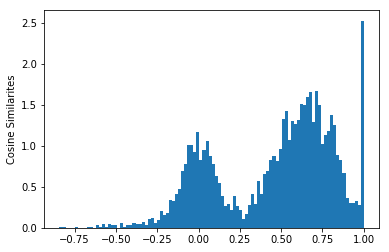

In [18]:
plt.hist(cosine_similarites, normed=True, bins=100)
plt.ylabel('Cosine Similarites')

In [19]:
threshold = 0.75

In [58]:
def Neighbourhood(lr,col_list,thre):
    sim = []
    lr_DE = Doc2vec(lr)
    for lr2 in col_list:
        sim.append(cosin(lr_DE,Doc2vec(lr2)))

    final = []
    final_cosin = []
    for i in range(0,len(col_list)):
        if(thre-0.05<=sim[i] and sim[i]<thre+0.05):
            final.append(col_list[i])
            final_cosin.append(sim[i])
    final = [x for _,x in sorted(zip(final_cosin,final))]        
    final.reverse()
    return final[:min(5,len(final))]       

In [21]:
# function to predict similarity between two text using svm model

def text_similarity_svm(text1, text2):
    
    dv1 = Doc2vec(text1)
    dv2 = Doc2vec(text2)
    
    wd1 = Word2vec(text1)
    wd2 = Word2vec(text1)
    
    ds = cosin(dv1,dv2)
    ws = cosin(wd1,wd2)

    clean_matrix1 = clean(text1).split()
    clean_matrix2 = clean(text2).split() 

    clean_matrix1 = dictionary.doc2bow(clean_matrix1)  
    clean_matrix2 = dictionary.doc2bow(clean_matrix2) 
    
    lda_1 = ldamodel.get_document_topics(clean_matrix1,per_word_topics=True)[0] 
    lda_2 = ldamodel.get_document_topics(clean_matrix2,per_word_topics=True)[0] 

#     print(lda_1)
#     lda_1 = clean_matrix1.apply(lambda x: ldamodel.get_document_topics(x,per_word_topics=True)[0])
#     lda_2 = clean_matrix1.apply(lambda x: ldamodel.get_document_topics(x,per_word_topics=True)[0])

    a_list=[]
    b_list=[]
    for i,j in lda_1:
        a_list.append(j)

    for i,j in lda_2:
        b_list.append(j)
    
    a_list=np.array(a_list)
    b_list=np.array(b_list)

    kl = np.sum(np.where(a_list!=0,a_list*np.log(a_list/b_list),0))    
    sc,nv =getNoveltySC(text1,text2)
    
    data=[]
    
    data.append(ds)
    data.append(ws)
    data.append(sc)
    data.append(nv)
    data.append(kl)
        
    similarity = svm_fun.predict_proba(np.array(data).reshape(1,5))[0][1]
    
    return similarity

In [22]:
# text_similarity_svm(allSummarizations[0],allSummarizations[0])

In [23]:
def getNextlr(pre_lr,candidates,similarity_function):
    lr = pre_lr
    simi_Scores = []
    for i in candidates:
#         print(type(i))
        simi_Scores.append(similarity_function(lr,i))
        
    total = sum(simi_Scores)
    
    prob = [x/total for x in simi_Scores]
    ran = np.random.choice(candidates, 1, p=prob)
    return ran    

In [25]:
# can = Neighbourhood(allSummarizations[0],allSummarizations[:2],threshold)
# print((len(can)))
# getNextlr(allSummarizations[0],can,text_similarity_svm)


In [59]:
def generate_collection(start_lr,allresources,pathway_length,threshold,similarity_function):
    previous_lr = None
    present_lr = start_lr
    final_collection = [start_lr]
    next_lr = None 
    validator = 0
    i = 1
    while(i<pathway_length):
        nearto_present_lr = Neighbourhood(present_lr,allresources,threshold)        
        if(i==1):
            print("Value of i is:",i)
            next_lr = getNextlr(present_lr,nearto_present_lr,similarity_function)
            if(len(next_lr)==0):return final_collection
            else : next_lr = next_lr[0]
            final_collection.append(next_lr)
            previous_lr = present_lr
            present_lr = next_lr
            i+= 1
        if(i>1):
            while(len(nearto_present_lr)!=0):
                print("Value of i is:",i)
                next_lr = getNextlr(present_lr,nearto_present_lr,similarity_function)
                if(len(next_lr)==0):
                    return final_collection
                else:
                    next_lr =next_lr[0]
                score = get_validator_score(final_collection[i-2],final_collection[i-1],next_lr)
                print(score)
                if (score >= 0.70):
                        final_collection.append(next_lr)
                        previous_lr = present_lr
                        present_lr = next_lr
                        i+= 1
                        break
                elif (score < 0.70):
                    nearto_present_lr.remove(next_lr)
                    
            if(len(nearto_present_lr)==0):
                    present_lr = previous_lr
                    previous_lr = final_collection[i-2]
                    if(i>=1): 
                        i = i-1
                        final_collection.pop(i)
                    else: return final_collection
    return final_collection

In [60]:
warnings.filterwarnings('ignore')
col1 = generate_collection(allSummarizations[1],allSummarizations,3,threshold,text_similarity_svm)

Value of i is: 1
Value of i is: 2
entered validator checking
left validator checking
0.7596993


In [61]:
for i in col1:
    print(i)
    print("-------------------------------------------------")

atom composed subatomic particle proton neutron electronsthe chemical property element determined electron arrangedwhat suppose would cause atom lose electronnational standard benchmark science literacy 4dh1 atom made positively charged nucleus surrounded negatively charged electronsthe nucleus composed proton neutron roughly mass differ proton positively charged neutron electric charge snb op15 take 5 bullet note scroll click launch complete activity
-------------------------------------------------
element shell k l n p 2 ne 2 8 ar 2 8 8 kr 2 8 18 8 xe 2 8 18 18 8 rn 2 8 18 32 18 8 octet rule atom form ion combine compound obtain electron configuration nearest noble gas usually mean 8 outer electronsthe octet rule ion formation stated atom form ion seek electron configuration like nearest noble gasnearest refers number representative element element noble gasthere three way illustrate this q5 use three method chemical reaction equation br diagram lewis diagram show bond form between 

In [ ]:
warnings.filterwarnings('ignore')
col1 = generate_collection(allSummarizations[1],allSummarizations,8,threshold,text_similarity_svm)

Value of i is: 1
Value of i is: 2
entered validator checking
left validator checking
0.7596993
Value of i is: 3
